Download and process workbench studies

In [4]:
import requests
import pandas as pd

In [16]:
base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/name/datatable/file'

In [19]:
studies = ['AN003284']

In [37]:
# download all study sheets
for study in studies:
    url = base_url.replace('name', study)
    pd.read_csv(url, sep='\t').to_csv('Studies/'+f'{study}.csv', index=False)


In [22]:
exdata = pd.read_csv(base_url, sep='\t')

In [24]:
exdata['Class'].value_counts()

Class
group:Healthy                    104
group:COVID_non-acute             96
group:COVID_ventilator            50
group:QC                          30
group:COVID_before_ventilator     14
group:-                           12
group:COVID_ICU-no vent            8
group:COVID_undecided              8
Name: count, dtype: int64

In [64]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import glob
import sspa

class WorkbenchDataset:
    '''AN003284.csv
    Class to process Metabolomics Workbench datasets
    '''

    def __init__(self, study_id, filepath, md_filter, outliers=None, pathway_level=False):
        self.study_id = study_id
        self.filepath = filepath
        self.md_filter = md_filter
        self.raw_data = None
        self.outliers = outliers
        self.pathway_level = pathway_level
        self.pathway_coverage = None
        self.pathway_data = None
        self.DA_metabolites = None
        self.node_name = study_id


        self.read_data(filepath)
        self.preprocess_data()
        # self.get_pathway_data()
        self.da_testing()

    def read_data(self, file_path):
        data = pd.read_csv('Studies/'+file_path)
        self.raw_data = data
        metadata = data['Class']
        self.metadata = metadata

        return data, metadata
    
    def preprocess_data(self):
        '''Preprocess data'''
        data_filt = self.raw_data.copy()
        data_filt.index = data_filt['Samples']
        

        # filter on metadata
        md_dict = dict(zip(self.raw_data['Samples'], self.raw_data['Class']))
        data_filt = data_filt[data_filt['Class'].isin(self.md_filter.values())]
        data_filt = data_filt.drop(columns=['Class', 'Samples'])
        # drop outliers
        if self.outliers:
            data_filt = data_filt.drop(self.outliers)

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' '], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        # Delete rows and columns where all values are 0 
        data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
        data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

        data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        data_scaled['Group'] = data_scaled.index.map(md_dict)
        self.processed_data = data_scaled

        return data_scaled


    def get_pathway_data(self):
        reactome_paths = sspa.process_gmt(infile='Reactome_Homo_sapiens_pathways_ChEBI_R88.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        # remove CHEBI: from column names
        data = self.processed_data
        data.columns = data.columns.str.removeprefix("CHEBI:")

        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
 
    def plot_qc(self):
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = 10 * self.processed_data.shape[1]
        data_long = self.processed_data.melt(id_vars='Group')
        sns.boxplot(data=data_long.iloc[0:normaliser, :], ax=ax2, hue='Group', x='variable', y='value')
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()


    def da_testing(self):

        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data

        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]



In [65]:
wbd = WorkbenchDataset(
    study_id='AN003284',
    filepath='AN003284.csv',
    md_filter={'Control': 'group:Healthy', 'Case': 'group:COVID_non-acute'}
)

Missingness: 0.00%
Number of differentially abundant metabolites: 221


In [54]:
wbd.raw_data

,Samples,Class,10-Hydroxycarbazepine,11-Aminoundecanoic acid,11-Nitro-1-undecene,1-(1Z-hexadecenyl)-sn-glycero-3-phosphocholine,12-Aminododecanoic acid,12-Hydroxydihydrochelirubine,1_3_5-Heptatriene,1_3-Dicyclohexylurea,...,Venlafaxine,Veronal,Vestitol,Xanthine,Xanthohumol,Zalcitabine,Zearalenone,(Z)-Thiamethoxam,α-Aspartylphenylalanine,γ-Linolenic acid ethyl ester
0,Blank_01_NEG,group:-,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Blank_01_POS,group:-,53738.86,41643.32,1072200.02,257028.77,649817.85,46375.86,414975.98,186092.77,...,147909.72,49519.94,34422.89,42630.79,347328.65,35830.38,1257002.03,95928.39,79625.29,2738388.20
2,Blank_02_NEG,group:-,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Blank_02_POS,group:-,53738.86,41643.32,1072200.02,257028.77,649817.85,46375.86,414975.98,186092.77,...,147909.72,49519.94,34422.89,42630.79,347328.65,35830.38,1257002.03,95928.39,79625.29,2738388.20
4,Pooled_QC_ID_01_NEG,group:-,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,QC7_POS,group:QC,200138.91,695737.21,1850553.12,2540378.42,1110362.14,287890.80,948417.60,309186.12,...,14028650.14,1070317.79,146263.81,29889544.23,680209.83,2141838.63,2761944.52,815547.51,1024852.61,19407375.24
318,QC8_NEG,group:QC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
319,QC8_POS,group:QC,181362.56,603708.77,1639089.28,2694813.76,1116427.54,278433.68,858830.80,358274.40,...,12307275.56,1590122.82,91581.91,26899556.76,15690605.15,1892207.29,2663767.92,543846.07,920649.46,20920344.63
320,QC9_NEG,group:QC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


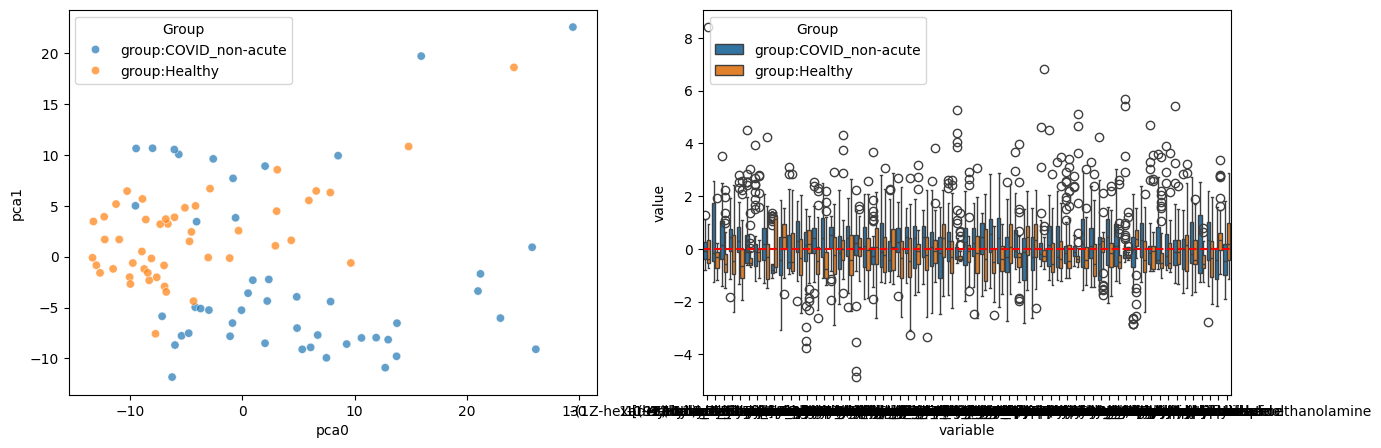

In [58]:
wbd.plot_qc()

In [55]:
wbd.processed_data

,10-Hydroxycarbazepine,11-Aminoundecanoic acid,11-Nitro-1-undecene,1-(1Z-hexadecenyl)-sn-glycero-3-phosphocholine,12-Aminododecanoic acid,12-Hydroxydihydrochelirubine,1_3_5-Heptatriene,1_3-Dicyclohexylurea,15-Crown-5,1_5-DAN,...,Veronal,Vestitol,Xanthine,Xanthohumol,Zalcitabine,Zearalenone,(Z)-Thiamethoxam,α-Aspartylphenylalanine,γ-Linolenic acid ethyl ester,Group
Samples,,,,,,,,,,,,,,,,,,,,,
Pat_01_POS,-0.391501,-0.499201,0.232962,-0.340687,0.424524,-0.051776,-0.076983,-0.223776,-0.770655,-0.099318,...,0.991515,0.098795,1.420591,0.267564,-0.111810,-0.291790,-0.303826,-0.051299,-0.111543,group:COVID_non-acute
Pat_03_POS,-0.589999,-0.098957,1.649410,0.552865,2.297518,-0.606541,-0.997592,0.452397,-0.755124,0.364911,...,0.287035,-0.126372,-0.044817,-0.718316,0.769660,-0.624635,1.715273,0.240359,0.184508,group:COVID_non-acute
Pat_04_POS,-0.450537,-0.294829,-0.855926,-1.147143,-0.553897,-0.506493,-0.556562,0.271765,-0.820207,0.753415,...,-0.089563,-0.573816,-0.346661,0.935750,0.692905,1.813176,4.919327,0.681933,0.136923,group:COVID_non-acute
Pat_101_POS,-0.396634,2.261386,2.489911,1.910740,1.143326,0.350345,-0.337939,0.229686,-0.889673,0.038285,...,1.490692,2.317180,0.867861,1.432907,2.026068,-0.034961,-0.172508,1.561939,1.405018,group:COVID_non-acute
Pat_106_POS,-0.192098,-0.130297,-1.010249,0.721273,0.259501,0.396961,-0.298268,0.227165,-0.892940,1.075959,...,0.503907,-0.586053,-0.735338,-0.275120,-0.129604,-1.163436,0.023437,-0.269417,-1.319953,group:COVID_non-acute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pat_63_POS,-0.456025,-0.945660,-0.710128,-2.149682,-0.382994,-0.337894,0.095227,-1.159067,0.905114,0.609132,...,0.720413,-0.109671,-0.538509,-0.752009,-1.217581,-0.841852,-0.330352,-1.037821,-1.119935,group:Healthy
Pat_64_POS,-0.552309,-0.593394,0.205598,-2.403159,0.057591,-0.666100,-0.100050,-0.181605,1.108699,-0.063562,...,-0.818165,-0.675902,0.369204,-0.803768,-1.279455,-0.566244,-0.514644,-0.658160,-1.720512,group:Healthy
Pat_65_POS,-0.421216,-1.121857,0.413272,-1.035559,-0.679266,-0.357643,-1.027838,-0.339538,1.340936,0.779569,...,-1.572709,-0.308169,0.315780,0.719183,-0.849549,-0.884239,-0.361195,-1.027380,-0.104388,group:Healthy
